In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('../data/cleaned_transactions.csv')
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_ratio,dest_balance_ratio
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,9839.64,0.0,False,False,True,False,0.942160,0.0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1864.28,0.0,False,False,True,False,0.912222,0.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,181.00,0.0,False,False,False,True,0.000000,0.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,181.00,-21182.0,True,False,False,False,0.000000,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,11668.14,0.0,False,False,True,False,0.719188,0.0


In [4]:
df_sample = df.sample(50000, random_state=42)

In [6]:
from sklearn.model_selection import train_test_split

# Separate features and label
X = df_sample.drop('isFraud', axis=1)
y = df_sample['isFraud']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(40000, 15) (10000, 15)


In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape, y_train_resampled.value_counts())


(79888, 15) isFraud
0    39944
1    39944
Name: count, dtype: int64


In [17]:
# Train
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print("LR ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9986
           1       0.03      0.93      0.07        14

    accuracy                           0.96     10000
   macro avg       0.52      0.95      0.52     10000
weighted avg       1.00      0.96      0.98     10000

LR ROC-AUC Score: 0.9266401533575577


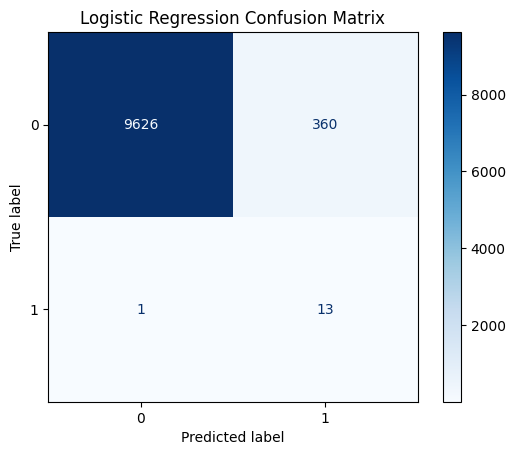

In [16]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.56      0.71      0.62        14

    accuracy                           1.00     10000
   macro avg       0.78      0.86      0.81     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9621684644216189


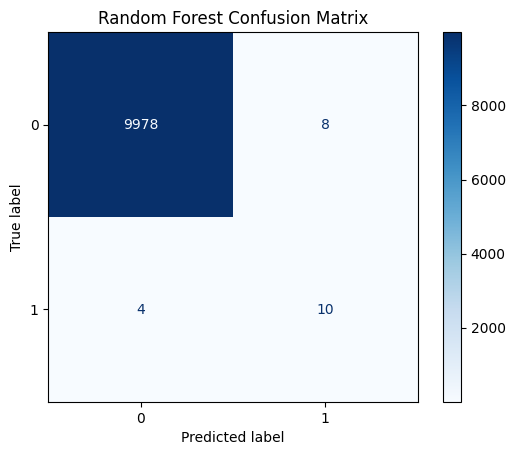

In [19]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

In [26]:
# Predict probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Set a custom threshold
threshold = 0.6
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.71      0.71      0.71        14

    accuracy                           1.00     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9621684644216189


In [27]:
from sklearn.model_selection import cross_val_score

# Run cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')

# Print results
print(f"Cross-Validation ROC-AUC Scores: {scores}")
print(f"Mean ROC-AUC Score: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")


Cross-Validation ROC-AUC Scores: [0.95311735 0.99985207 0.90753195 0.86031361 0.95706059]
Mean ROC-AUC Score: 0.9356
Standard Deviation: 0.0476


In [29]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define your base model
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# 2. Define hyperparameter space to search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],            # number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],              # depth of trees
    'min_samples_split': [2, 5, 10],                     # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                       # minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],            # number of features considered
    'bootstrap': [True, False]                           # use bootstrap samples?
}

# 3. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                    # try 50 random combinations
    cv=5,                         # 5-fold cross-validation
    verbose=2,                    # show progress
    random_state=42,
    scoring='roc_auc',             # still optimize for ROC-AUC
    n_jobs=-1                     # use all CPU cores
)

# 4. Fit
random_search.fit(X_train_resampled, y_train_resampled)

# 5. Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# 6. Best score during CV
print("Best ROC-AUC Score during CV:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; tot

/home/dosu/Documents/personal/fraud-detection/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
115 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dosu/Documents/personal/fraud-detection/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dosu/Documents/personal/fraud-detection/venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/dosu/Documents/personal/fraud-detection/venv/lib/python3.12

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best ROC-AUC Score during CV: 0.9999993607228536


In [31]:
# Train
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features='log2', bootstrap=False, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Set a custom threshold
threshold = 0.6
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.83      0.71      0.77        14

    accuracy                           1.00     10000
   macro avg       0.92      0.86      0.88     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9541500958484737


In [42]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [43]:
xgb_model.fit(X_train_resampled, y_train_resampled)


/home/dosu/Documents/personal/fraud-detection/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:42:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [44]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9986
           1       0.65      0.79      0.71        14

    accuracy                           1.00     10000
   macro avg       0.82      0.89      0.85     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9830655775228178


<Figure size 1000x600 with 0 Axes>

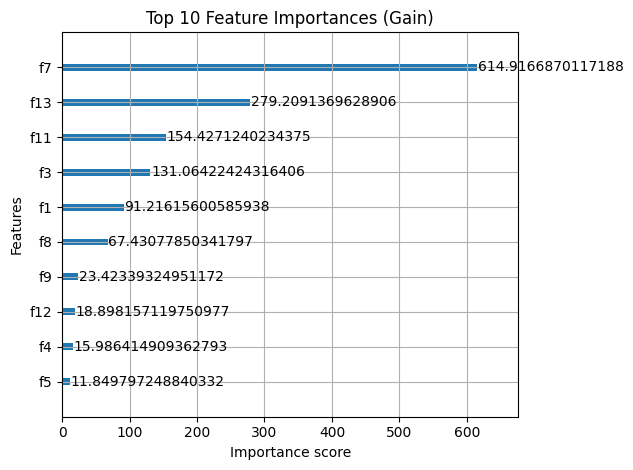

In [45]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.tight_layout()
plt.show()


In [48]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
sample = X_test_df.sample(100, random_state=42)

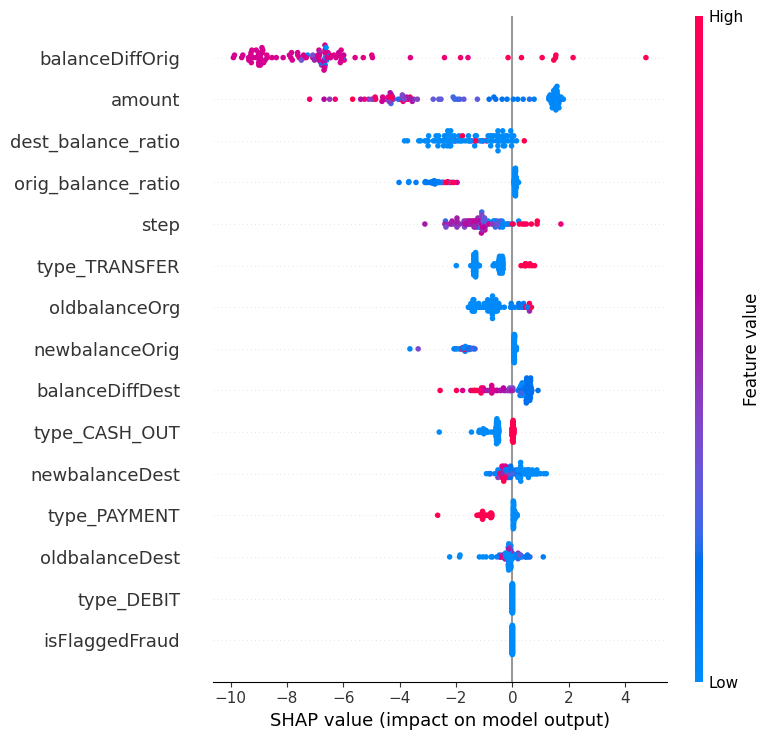

In [49]:
import shap

explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values
shap_values = explainer.shap_values(sample)

# Summary plot
shap.summary_plot(shap_values, sample)


In [50]:
plt.figure()
shap.summary_plot(shap_values, sample, show=False)  # Don't display yet
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=300)
plt.close()